# Goal: gathering statistics about performance of detection algorithm (generating a "detector spec" for future system-level statistical simulations)

### Note: much of the code built in this notebook has now been implemented in `ray_delay/ray_detector.py` for easier use in further experiments.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath
import dill as pickle

from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.ray_detector import RayDetectorSpec, RayDetector
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

In [2]:
dx = 11
dz = 11
dm = 7

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True
center_coords = patch.patch.device[dx][dz].coords

In [3]:
ray_radius = 6

In [4]:
syndrome_qubits = patch.patch.get_syndrome_qubits()

In [5]:
patch.reset()
baseline_fractions = np.mean(patch.patch.count_detection_events(1e6, return_full_data=True)[0], axis=0)

ray_fractions = []
times = np.linspace(0, 30e-3, 10)
for time in times:
    patch.reset()
    patch.force_cosmic_ray_by_coords(center_coords)
    patch.step(time)
    ray_fractions.append(np.mean(patch.patch.count_detection_events(1e6, return_full_data=True)[0], axis=0))

baseline_fractions_labeled = {q.idx: baseline_fractions[i] for i,q in enumerate(syndrome_qubits)}
ray_fractions_labeled = [{q.idx:r[i] for i,q in enumerate(syndrome_qubits)} for r in ray_fractions]

In [6]:
def _initialize_windows(
        device: list[list[Qubit | None]],
        spatial_window_size: int,
        only_full_windows: bool = False,
    ) -> list[list[int]]:
    """Initialize spatial windows that we will use to detect cosmic rays.
    
    Args:
        device: The layout of the device, in the form of a 2D list of Qubit
            objects.
    """
    assert spatial_window_size < len(device) and spatial_window_size < len(device[0])
    window_rows = (len(device) - spatial_window_size)//2 + 1
    window_cols = (len(device[0]) - spatial_window_size)//2 + 1

    min_qubit_count = spatial_window_size**2 if only_full_windows else 1

    all_windows = []
    for wr in range(window_rows):
        for wc in range(window_cols):
            window_qubits = []
            for r in range(wr, wr + spatial_window_size):
                for c in range(wc, wc + spatial_window_size):
                    qb = device[2*r][2*c]
                    if isinstance(qb, MeasureQubit):
                        window_qubits.append(qb.idx)
            if len(window_qubits) >= min_qubit_count:
                all_windows.append(window_qubits)
    return all_windows

In [7]:
mpmath.mp.dps = 50

cycles_per_distillation = 6*dm
max_latency = cycles_per_distillation

thresholds = [1-mpmath.mpf(1e-9), 1-mpmath.mpf(1e-10), 1-mpmath.mpf(1e-11), 1-mpmath.mpf(1e-13), 1-mpmath.mpf(1e-15)]
temporal_window_size = max_latency
spatial_size = 2

detector_windows = _initialize_windows(patch.patch.device, spatial_size, only_full_windows=True)

In [8]:
distances = np.zeros(len(patch.patch.ancilla), dtype=float)
# center_coords = patch.patch.qubit_name_dict[center_qubit].coords

for i,qubit in enumerate(patch.patch.ancilla):
    coords = qubit.coords
    distances[i] = np.sqrt((coords[0]-center_coords[0])**2 + (coords[1]-center_coords[1])**2)

In [9]:
unique_distances = []
qubits_per_distance = []
for i,dst in enumerate(distances):
    qubit = patch.patch.ancilla[i].idx
    dst_rounded = np.round(dst, 2)
    if dst_rounded not in unique_distances:
        unique_distances.append(dst_rounded)
        qubits_per_distance.append([qubit])
    else:
        qubits_per_distance[unique_distances.index(dst_rounded)].append(qubit)

In [10]:
qubits_per_distance = np.array(qubits_per_distance, dtype=object)[np.argsort(unique_distances)]
unique_distances = np.sort(unique_distances)

In [11]:
first_distillation_signal_rate_by_distance = np.zeros((len(thresholds), max_latency, len(unique_distances)), dtype=mpmath.mpf)
signal_rates = np.zeros((len(thresholds), max_latency, len(detector_windows)), dtype=mpmath.mpf)
for i,threshold in enumerate(thresholds):
    for latency in range(max_latency):
        for k,window in enumerate(detector_windows):
            baseline_mean = np.mean([baseline_fractions_labeled[q] for q in window]) # mean per qubit per round
            ray_mean = np.mean([ray_fractions_labeled[0][q] for q in window])

            # threshold of detections where we say it is outside of the baseline regime
            detection_threshold = scipy.stats.binom.ppf(float(threshold), len(window)*temporal_window_size, baseline_mean)
        
            if latency <= temporal_window_size:
                # some part of window is at baseline rate (before ray has hit)
                windowed_syndrome_rate = baseline_mean*(1-latency/temporal_window_size) + ray_mean*(latency/temporal_window_size)
            else:
                windowed_syndrome_rate = ray_mean
            detection_prob = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, windowed_syndrome_rate)
            signal_rates[i,latency,k] = mpmath.mpf(detection_prob)

qubit_no_signal_rates = np.ones((len(thresholds), max_latency, len(patch.patch.all_qubits)), dtype=mpmath.mpf)
for i,threshold in enumerate(thresholds):
    for latency in range(max_latency):
        for k,window in enumerate(detector_windows):
            signal_rate = signal_rates[i,latency,k]
            for q in window:
                qubit_no_signal_rates[i,latency,q] *= (1-signal_rate)

no_ray_signal_rates = 1-qubit_no_signal_rates[:,0]
false_positive_rate = np.mean(no_ray_signal_rates, axis=1)

for k,dst in enumerate(unique_distances):
    for q in qubits_per_distance[k]:
        first_distillation_signal_rate_by_distance[:,:,k] += (1-qubit_no_signal_rates[:,:,q])
    first_distillation_signal_rate_by_distance[:,:,k] /= len(qubits_per_distance[k])

    # lower bound by average false positive rate
    for latency in range(max_latency):
        first_distillation_signal_rate_by_distance[:,latency,k] = np.maximum(first_distillation_signal_rate_by_distance[:,latency,k], false_positive_rate)

In [12]:
false_positive_rate

array([mpf('0.00000000072125130531688689484966790144515564442700750880491826'),
       mpf('0.000000000055986577289164677188836404481261237813137097070925078'),
       mpf('0.0000000000045982434088854261100702703536195878808338548114575781'),
       mpf('0.000000000000050373720870002217440392244371716032165136370967176394'),
       mpf('0.00000000000000054543736977435046849777761614877767425976916314313092')],
      dtype=object)

In [13]:
decaying_signal_rate_by_distance = np.zeros((len(thresholds), len(times), len(unique_distances)), dtype=mpmath.mpf)
signal_rates = np.zeros((len(thresholds), len(times), len(detector_windows)), dtype=mpmath.mpf)
for i,threshold in enumerate(thresholds):
    for j,time in enumerate(times):
        for k,window in enumerate(detector_windows):
            windowed_syndrome_rate = np.mean([ray_fractions_labeled[j][q] for q in window])

            # threshold of detections where we say it is outside of the baseline regime
            detection_threshold = scipy.stats.binom.ppf(float(threshold), len(window)*temporal_window_size, baseline_mean)

            detection_prob = 1-scipy.stats.binom.cdf(detection_threshold, len(window)*temporal_window_size, windowed_syndrome_rate)
            signal_rates[i,j,k] = mpmath.mpf(detection_prob)

qubit_no_signal_rates = np.ones((len(thresholds), len(times), len(patch.patch.all_qubits)), dtype=mpmath.mpf)
for i,threshold in enumerate(thresholds):
    for j,time in enumerate(times):
        for k,window in enumerate(detector_windows):
            signal_rate = signal_rates[i,j,k]
            for q in window:
                qubit_no_signal_rates[i,j,q] *= (1-signal_rate)

for k,dst in enumerate(unique_distances):
    for q in qubits_per_distance[k]:
        decaying_signal_rate_by_distance[:,:,k] += (1-qubit_no_signal_rates[:,:,q])
    decaying_signal_rate_by_distance[:,:,k] /= len(qubits_per_distance[k])

    # lower bound by average false positive rate
    for j,time in enumerate(times):
        decaying_signal_rate_by_distance[:,j,k] = np.maximum(decaying_signal_rate_by_distance[:,j,k], false_positive_rate)

In [14]:
from ray_delay.ray_detector import RayDetectorSpec

In [15]:
for i,threshold in enumerate(thresholds):
    ray_detector_spec = RayDetectorSpec(
        detector_spatial_window_size = spatial_size,
        detector_temporal_window_size = temporal_window_size,
        ray_params = patch.noise_params.cosmic_ray_params,
        detection_distances = unique_distances,
        times_after_ray_impact = times,
        first_distillation_signal_rates = first_distillation_signal_rate_by_distance[i],
        decaying_signal_rates = decaying_signal_rate_by_distance[i],
        baseline_signal_rate = false_positive_rate.astype(float)[i]
    )
    pickle.dump(ray_detector_spec, open(f'detection_chance_functions/linear_err_thresh=1e{int(np.round(np.log10(float(1-threshold))))}.pkl', 'wb'))

In [16]:
decaying_signal_rate_by_distance[0,:,4]

array([mpf('0.84571633855316126699555690077923688168591497927804203'),
       mpf('0.00010190424958876874437668692487349869402631442709623249'),
       mpf('0.0000016136412234882040153082125164152208056091474348440911'),
       mpf('0.00000019610777141617984485496122751847316415333118112008631'),
       mpf('0.000000057504804517341697617816916507648686801010020653426424'),
       mpf('0.000000026593753451803990741440716229323804946492798496702903'),
       mpf('0.000000015917760097783862762829944549867986418804020624128656'),
       mpf('0.000000011222344459410395737824172924912252659935145931314398'),
       mpf('0.0000000088397685019827454544549312667343696961456753113629711'),
       mpf('0.0000000076530565984459498799706562343356314150178269795596874')],
      dtype=object)

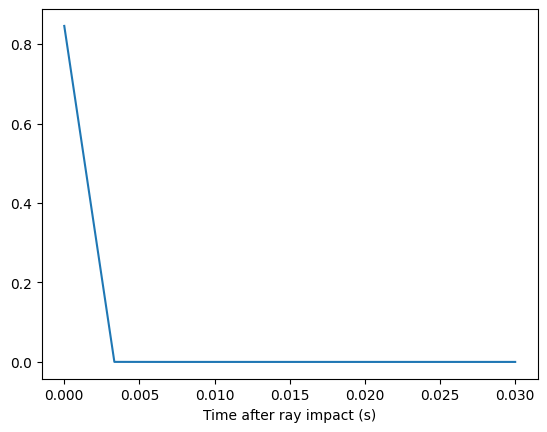

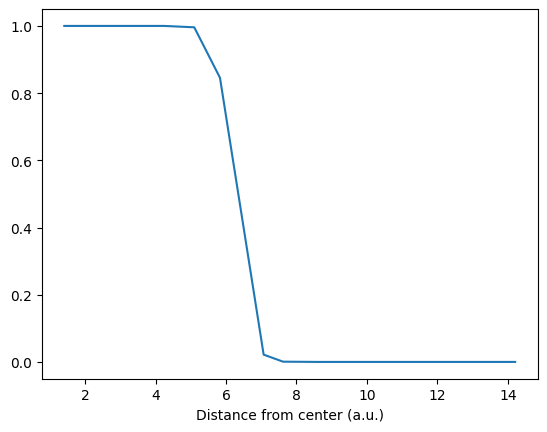

In [17]:
plt.plot(times, decaying_signal_rate_by_distance[0,:,4].T)
plt.xlabel('Time after ray impact (s)')
plt.show()

plt.plot(unique_distances, decaying_signal_rate_by_distance[0,0,:].T)
plt.xlabel('Distance from center (a.u.)')
plt.show()